In [1]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('/content/drive/MyDrive/1 Belajar/dicoding/Pengembangan Machine Learning/transactions.csv',parse_dates=['date'])
df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [8]:
df.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [9]:
df_final = df[['date','transactions']]
df_final.set_index('date', inplace= True)
df_final.head()

,transactions
date,
2013-01-01,770
2013-01-02,2111
2013-01-02,2358
2013-01-02,3487
2013-01-02,1922


In [10]:
df_final.shape

(83488, 1)

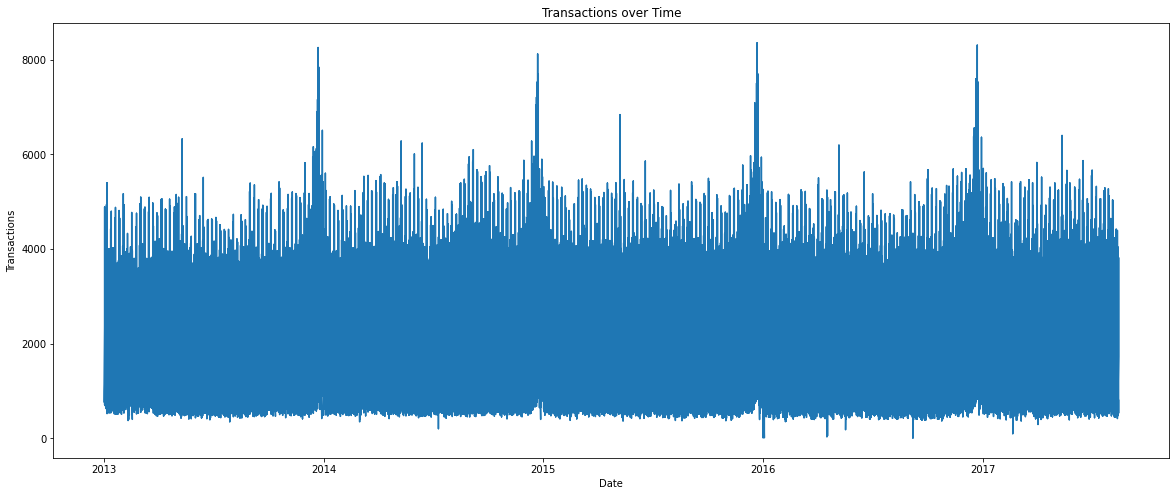

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(df_final)
plt.title('Transactions over Time')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.show()

In [26]:
date = df['date'].values
transactions = df['transactions'].astype(float).values

In [14]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(transactions, date, test_size = 0.2, random_state = 0 , shuffle=False)
x_train.shape, x_test.shape

((66790,), (16698,))

In [28]:
x_train_window = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
x_test_window  = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

In [29]:
from keras.layers import Dense, LSTM

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae', 'mse'])

In [47]:
x = (df['transactions'].max() - df['transactions'].min()) * (0.1)
x

835.4000000000001

In [36]:
x

835.4000000000001

In [48]:
# Create class of callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [49]:
history = model.fit(x_train_window, 
                    epochs=100, 
                    validation_data=x_test_window,
                    batch_size=64, 
                    callbacks=[callbacks])

Epoch 1/100
    668/Unknown - 81s 120ms/step - loss: 687.2925 - mae: 687.7934 - mse: 1014668.7500
MAE of the model < 10% of data scale
668/668 [==============================] - 89s 132ms/step - loss: 687.2925 - mae: 687.7934 - mse: 1014668.7500 - val_loss: 676.9200 - val_mae: 677.4199 - val_mse: 1063336.0000


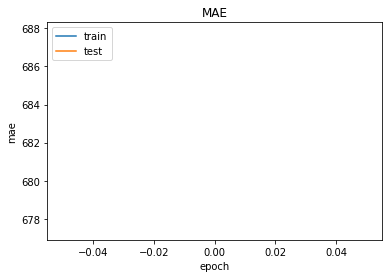

In [50]:
# plot of mae
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()